<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#LSMS-Data-Structure" data-toc-modified-id="LSMS-Data-Structure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSMS Data Structure</a></span><ul class="toc-item"><li><span><a href="#plot-locations" data-toc-modified-id="plot-locations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>plot locations</a></span></li><li><span><a href="#Country-/-Year-of-Data" data-toc-modified-id="Country-/-Year-of-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Country / Year of Data</a></span></li><li><span><a href="#Check-for-&quot;panel&quot;" data-toc-modified-id="Check-for-&quot;panel&quot;-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Check for "panel"</a></span></li><li><span><a href="#Uniqueness-of-lat-for-each-lon" data-toc-modified-id="Uniqueness-of-lat-for-each-lon-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Uniqueness of lat for each lon</a></span></li></ul></li><li><span><a href="#Create-incountry-folds" data-toc-modified-id="Create-incountry-folds-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create incountry folds</a></span><ul class="toc-item"><li><span><a href="#Create-country-labels" data-toc-modified-id="Create-country-labels-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create country labels</a></span></li></ul></li><li><span><a href="#Labels" data-toc-modified-id="Labels-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Labels</a></span><ul class="toc-item"><li><span><a href="#Overall-Label-Distribution" data-toc-modified-id="Overall-Label-Distribution-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Overall Label Distribution</a></span></li><li><span><a href="#Households" data-toc-modified-id="Households-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Households</a></span></li><li><span><a href="#Distributions-per-fold" data-toc-modified-id="Distributions-per-fold-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Distributions per fold</a></span></li></ul></li><li><span><a href="#Visualize-Images" data-toc-modified-id="Visualize-Images-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize Images</a></span><ul class="toc-item"><li><span><a href="#Highest-wealth" data-toc-modified-id="Highest-wealth-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Highest wealth</a></span></li><li><span><a href="#Lowest-wealth" data-toc-modified-id="Lowest-wealth-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Lowest wealth</a></span></li></ul></li></ul></div>

Prerequisites:
1. Run the first couple of sections from `models/baselines_lsms.ipynb` to create `data/lsms_image_hists.npz`.
2. Run `data_analysis/lsms_merge_dfs.ipynb` to create `data/lsms_wealth_index.csv`.

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import itertools
import os
import pickle
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append('../')
from batchers import batcher, dataset_constants
from data_analysis.create_folds import create_folds, verify_folds
from utils.general import colordisplay, load_npz
from utils.geo_plot import setup_ax
from utils.plot import heatmap, boxplot_df, plot_image_by_band

In [3]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'NIGHTLIGHTS']

# Load Data

In [4]:
LSMS_CSV_PATH = '../data/lsms_wealth_index.csv'
lsms_df = pd.read_csv(LSMS_CSV_PATH, float_precision='high')
lsms_df['lat'] = lsms_df['lat'].astype(np.float32)
lsms_df['lon'] = lsms_df['lon'].astype(np.float32)
print(lsms_df.dtypes)

with pd.option_context('display.max_rows', 8):
    display(lsms_df)

lat            float32
lon            float32
year             int64
country         object
index_all      float64
ea_id            int64
index_rep      float64
et_index       float64
n              float64
geolev1         object
geolev2         object
rooms          float64
electric       float64
phone          float64
radio          float64
tv             float64
auto           float64
floor_qual     float64
toilet_qual    float64
watsup_qual    float64
dtype: object


lat        lon  year   country  index_all       ea_id  index_rep  \
0    -0.292248  31.478722  2005    uganda   0.045405     1110003   0.042136   
1    -0.292248  31.478722  2009    uganda  -0.333650     1110003  -0.326794   
2    -0.292248  31.478722  2013    uganda  -0.386531     1110003  -0.373920   
3    -0.439120  31.711950  2005    uganda   0.310049           0   0.301829   
...        ...        ...   ...       ...        ...         ...        ...   
3016  9.917938  11.689417  2010   nigeria  -0.688097         590  -0.683124   
3017  9.917938  11.689417  2015   nigeria   0.119982         590   0.017382   
3018  9.991906  37.692554  2011  ethiopia  -1.261734  3061102207  -1.259458   
3019  9.991906  37.692554  2015  ethiopia  -1.187214  3061102207  -1.186825   

      et_index    n geolev1   geolev2     rooms  electric  phone  radio    tv  \
0          NaN  8.0  UGA.53  UGA.53.2  4.125000  0.000000  0.125   0.75  0.75   
1          NaN  8.0  UGA.53  UGA.53.2  3.000000  0.000000  0.500   0.75  0.00   
2          NaN  8.0  UGA.53  UGA.53.2  2.375000  0.000000  0.375   0.75  0.00   
3          NaN  1.0  UGA.35  UGA.35.2  6.000000  0.000000  0.000   1.00  1.00   
...        ...  ...     ...       ...       ...       ...    ...    ...   ...   
3016       NaN  1.0  NGA.16  NGA.16.2  3.000000  0.000000  0.000   1.00  0.00   
3017       NaN  1.0  NGA.16  NGA.16.2  3.000000  1.000000  0.000   1.00  0.00   
3018 -0.730667  9.0   ETH.3   ETH.3.7  1.666667  0.000000  0.000   0.00  0.00   
3019 -0.621825  9.0   ETH.3   ETH.3.7  1.777778  0.111111  0.000   0.00  0.00   

      auto  floor_qual  toilet_qual  watsup_qual  
0      0.0       1.750     3.250000        3.500  
1      0.0       1.000     3.750000        3.625  
2      0.0       1.375     3.875000        3.000  
3      0.0       1.000     4.000000        3.000  
...    ...         ...          ...          ...  
3016   0.0       2.000     1.000000        4.000  
3017   0.0       2.000     3.000000        4.000  
3018   0.0       1.000     1.000000        3.000  
3019   0.0       1.000     1.111111        3.000  

[3020 rows x 20 columns]

In [5]:
print('num villages:', len(lsms_df))
print('num villages w/ household info:', lsms_df['n'].notna().sum())

num villages: 3020
num villages w/ household info: 2915


In [6]:
mean_households = lsms_df.groupby(['lat', 'lon'])['n'].agg(['mean', 'min', 'max']).dropna()
display(mean_households.loc[mean_households['min'] != mean_households['max']])

mean  min   max
lat       lon                           
-0.987177 30.129835  9.666667  9.0  10.0
-0.887125 31.711088  6.666667  6.0   7.0
-0.867663 30.354115  8.666667  8.0   9.0
-0.860807 30.269276  5.666667  5.0   6.0
-0.760571 30.179094  6.666667  6.0   7.0
-0.576782 31.691637  7.666667  7.0   8.0
 0.039344 32.540386  6.666667  6.0   7.0
 0.058414 29.949335  9.666667  9.0  10.0
 0.071610 32.092873  9.666667  9.0  10.0
 0.365141 32.597015  5.666667  5.0   6.0
 0.552687 31.382027  3.666667  3.0   4.0
 0.578552 30.161201  8.666667  8.0   9.0
 0.640799 30.301283  5.666667  5.0   6.0
 0.696135 34.002964  7.666667  7.0   8.0
 0.696242 34.109386  7.333333  6.0   8.0
 0.732910 32.958759  4.666667  4.0   5.0
 1.260800 33.797054  7.333333  6.0   8.0
 1.372140 33.907967  7.666667  7.0   8.0
 1.834834 32.384174  9.666667  9.0  10.0
 2.356898 31.417545  8.333333  7.0   9.0
 2.505306 32.383907  7.666667  7.0   8.0

In [7]:
COUNTRIES = sorted(lsms_df['country'].unique())
YEARS = np.arange(lsms_df['year'].min(), lsms_df['year'].max() + 1)

country_to_years = {
    'ethiopia': [2011, 2015],
    'malawi': [2010, 2016],
    'nigeria': [2010, 2015],
    'tanzania': [2008, 2012],
    'uganda': [2005, 2009, 2013],
}

In [8]:
# check that (lat, lon, year) is unique across the DataFrame
assert len(set(map(tuple, lsms_df[['lat', 'lon', 'year']].values))) == len(lsms_df)

# LSMS Data Structure

## plot locations

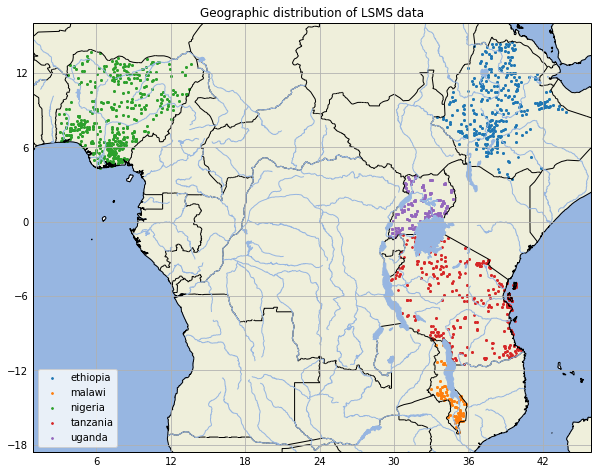

In [9]:
fig = plt.figure(figsize=[10, 10])
ax = setup_ax(fig)
for c, group_df in lsms_df.groupby('country'):
    locs = group_df[['lat', 'lon']].values
    ax.scatter(x=locs[:, 1], y=locs[:, 0], label=c, s=3)
ax.legend()
ax.set_title('Geographic distribution of LSMS data')
plt.show()

## Country / Year of Data

country  ethiopia      malawi      nigeria      tanzania      uganda          
year         2011 2015   2010 2016    2010 2015     2008 2012   2005 2009 2013
num_locs      329  329    102  102     481  481      371  328    166  165  166

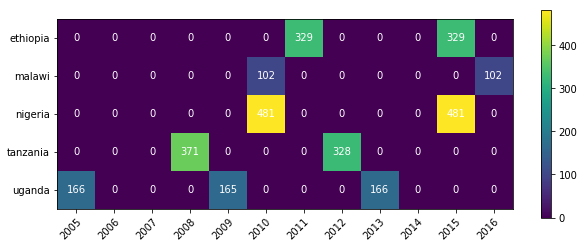

In [10]:
def country_year_heatmap(lsms_df):
    cys_series = lsms_df.groupby(['country', 'year']).size().rename('num_locs')
    display(cys_series.to_frame().T)

    mat = np.zeros([len(COUNTRIES), len(YEARS)], dtype=np.int32)

    for i, c in enumerate(COUNTRIES):
        for j, y in enumerate(YEARS):
            mat[i, j] = cys_series.get(key=(c, y), default=0.0)

    heatmap(mat=mat, xlabels=YEARS, ylabels=COUNTRIES,
            format_spec='{:d}')

country_year_heatmap(lsms_df)

## Check for "panel"

In [11]:
def check_for_panel(lsms_df):
    check_panel_data = []  # (country, y1, y2, diff (y1-y2), diff (y2-y1))
    for c, country_df in lsms_df.groupby('country'):
        year_to_locs = {}  # int => set
        cyears = country_df['year'].unique()
        for y in cyears:
            locs = country_df.loc[country_df['year'] == y, ['lat', 'lon']].values
            year_to_locs[y] = set(map(tuple, locs))
        for ya, yb in itertools.combinations(cyears, r=2):
            y1, y2 = min(ya, yb), max(ya, yb)
            diff_y1_y2 = len(year_to_locs[y1] - year_to_locs[y2])
            diff_y2_y1 = len(year_to_locs[y2] - year_to_locs[y1])
            row = [c, y1, y2, diff_y1_y2, diff_y2_y1]
            check_panel_data.append(row)

    check_panel_df = pd.DataFrame.from_records(
        data=check_panel_data,
        columns=['country', 'y1', 'y2', 'diff (y1-y2)', 'diff (y2-y1)'])
    check_panel_df.sort_values(['country', 'y1', 'y2'], inplace=True)
    display(check_panel_df)

check_for_panel(lsms_df)

country    y1    y2  diff (y1-y2)  diff (y2-y1)
0  ethiopia  2011  2015             2             2
1    malawi  2010  2016             0             0
2   nigeria  2010  2015             1             1
3  tanzania  2008  2012            48             5
4    uganda  2005  2009             1             0
5    uganda  2005  2013             0             0
6    uganda  2009  2013             0             1

## Uniqueness of lat for each lon

- lons are not unique
- `(lon, country)` is unique (so `(lat, lon, country)` is also unique)

In [12]:
unique_locs = lsms_df[['lat', 'lon']].drop_duplicates().values
assert unique_locs.dtype == np.float32
print('Number of unique locations:', len(unique_locs))

noverlap_lons = lsms_df.groupby('lon')['lat'].agg(lambda x: x.nunique() > 1).sum()
print('Number of lons with >1 matching lats:', noverlap_lons)

Number of unique locations: 1457
Number of lons with >1 matching lats: 1


In [13]:
# check uniqueness of (lon, country)
noverlap_lons = lsms_df.groupby(['lon', 'country'])['lat'].agg(lambda x: x.nunique() > 1).sum()
print('Number of (lon, country) with >1 matching lats:', noverlap_lons)
assert noverlap_lons == 0

Number of (lon, country) with >1 matching lats: 0


# Create incountry folds

This section assumes that `preprocessing/process_tfrecords_lsms.ipynb` and `models/baselines_lsms.ipynb` have already been run because it loads the image histograms `npz` file.

Maximum side lengths in degrees lat/lon of a 224x224 px image at 30m/px

```
maximum side_lat: 0.060570
maximum side_lon: 0.070361
```
(see `data_analysis/dhs.ipynb`)

In [14]:
npz = load_npz('../data/lsms_image_hists.npz')
locs = npz['locs']
labels = npz['labels']
years = npz['years']

image_hists: dtype=int64, shape=(3020, 8, 102)
labels: dtype=float32, shape=(3020,)
locs: dtype=float32, shape=(3020, 2)
years: dtype=int32, shape=(3020,)
nls_center: dtype=float32, shape=(3020,)
nls_mean: dtype=float32, shape=(3020,)


num clusters: 166
max cluster size: 54
num outliers: 870


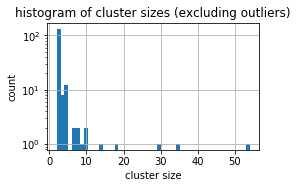

A B 0.09316818668795265
A C 0.09698635776641168
A D 0.0944328306997889
A E 0.09506203687192395
B C 0.09334907897727049
B D 0.09566940873908972
B E 0.09298662248251378
C D 0.09664187084455265
C E 0.09629685083778979
D E 0.09429247629973826
Size of each fold
{'A': 604, 'B': 604, 'C': 604, 'D': 604, 'E': 604}


In [15]:
MIN_DIST = 0.092841  # np.sqrt(0.060570**2 + 0.070361**2)
DIST_METRIC = 'euclidean'

locs_to_indices, incountry_folds = create_folds(
    locs, min_dist=MIN_DIST, dist_metric=DIST_METRIC, fold_names=FOLDS)
verify_folds(incountry_folds, locs=locs, min_dist=MIN_DIST,
             dist_metric=DIST_METRIC, max_index=3020)

print('Size of each fold')
sizes = {}
for fold, indices in incountry_folds.items():
    assert len(indices) == 604  # check fold size
    sizes[fold] = len(indices)
pprint(sizes)

# create train/val/test splits
folds = {}
for i, f in enumerate(FOLDS):
    folds[f] = {}
    folds[f]['test'] = incountry_folds[f]

    val_f = FOLDS[(i+1) % 5]
    folds[f]['val'] = incountry_folds[val_f]

    train_fs = [FOLDS[(i+2) % 5], FOLDS[(i+3) % 5], FOLDS[(i+4) % 5]]
    folds[f]['train'] = np.sort(np.concatenate([incountry_folds[f] for f in train_fs]))

In [16]:
file_path = '../data/lsms_incountry_folds.pkl'
if not os.path.exists(file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(folds, f)

with open(file_path, 'rb') as f:
    saved_folds = pickle.load(f)
for f in FOLDS:
    for split in SPLITS:
        assert np.array_equal(folds[f][split], saved_folds[f][split])

## Create country labels

In [17]:
# create mapping: loc => country
loc_to_country = (lsms_df
    .groupby(['lat', 'lon'])
    .apply(lambda df: df['country'].iloc[0])
    .to_dict())

In [18]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(lsms_df), dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_to_country[tuple(loc)]
    country_indices[country].append(i)

for i, country in enumerate(dataset_constants.LSMS_COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

# Labels

## Overall Label Distribution

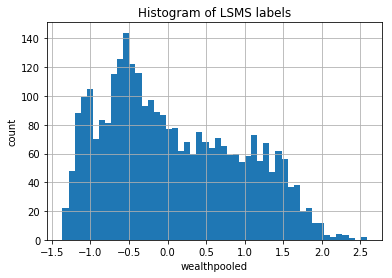

In [19]:
ax = lsms_df['index_all'].hist(bins=50)
ax.set_xlabel('wealthpooled')
ax.set_ylabel('count')
ax.set_title('Histogram of LSMS labels')
plt.show()

In [20]:
lsms_country = lsms_df.groupby('country')['index_all'].describe()
colordisplay(lsms_country)

In [21]:
cy_multiindex = lsms_df.groupby(['country', 'year']).size().index
display(cy_multiindex)

CMAP_FN = plt.cm.get_cmap('Set2')
COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 8] for i in cy_multiindex.codes[0]]

MultiIndex(levels=[['ethiopia', 'malawi', 'nigeria', 'tanzania', 'uganda'], [2005, 2008, 2009, 2010, 2011, 2012, 2013, 2015, 2016]],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4], [4, 7, 3, 8, 3, 7, 1, 5, 0, 2, 6]],
           names=['country', 'year'])

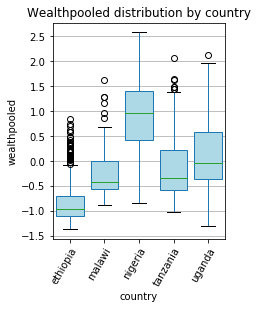

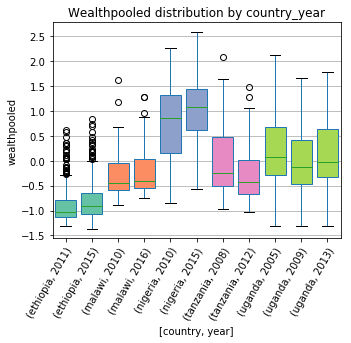

In [22]:
boxplot_df(lsms_df, y='index_all', by='country',
           figsize=[3, 4], ylabel='wealthpooled',
           title='Wealthpooled distribution by country',
           colors=['lightblue'] * len(COUNTRIES))

boxplot_df(lsms_df, y='index_all', by=['country', 'year'],
           figsize=[5, 4], ylabel='wealthpooled',
           title='Wealthpooled distribution by country_year',
           colors=COUNTRY_YEAR_COLORS)

## Households

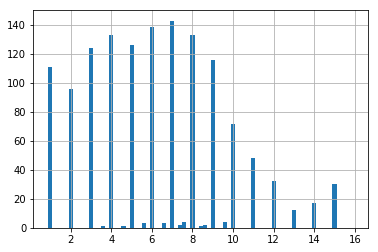

In [23]:
_ = mean_households['mean'].hist(bins=np.arange(0.9, 16.1, 0.2))

## Distributions per fold

In [24]:
def my_func(s):
    '''
    Args
    - s: pd.Series, index=['lat', 'lon'], type float32, represents a single location

    Returns
    - fold: str, the name of the test fold that the loc belongs to
    '''
    indices = locs_to_indices[(s['lat'], s['lon'])]
    i = indices[0]
    for f in folds:
        if i in folds[f]['test']:
            return f

lsms_df['test_fold'] = lsms_df[['lat', 'lon']].apply(my_func, axis=1)

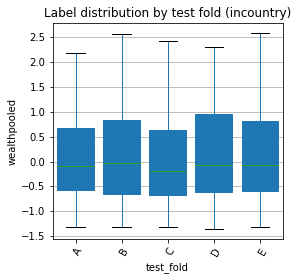

In [25]:
boxplot_df(lsms_df, y='index_all', by='test_fold',
           figsize=[4, 4], ylabel='wealthpooled',
           title='Label distribution by test fold (incountry)')

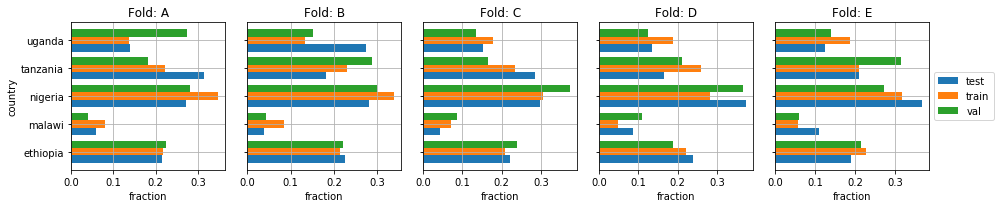

In [26]:
def plot_countries_by_split(folds, country_indices):
    '''
    Args
    - folds: dict, folds[f][split] is a np.array of indices
    - country_indices: dict, country (str) => np.array of indices
    '''
    fig, axs = plt.subplots(1, 5, figsize=[14, 3], sharey=True)
    for f, ax in zip(FOLDS, axs.flat):
        data = []
        for split in folds[f]:
            for country, indices in country_indices.items():
                count = len(np.intersect1d(folds[f][split], indices))
                row = (split, country, count)
                data.append(row)
        df = pd.DataFrame.from_records(data, columns=['split', 'country', 'count'])
        df['count'] /= df.groupby('split')['count'].transform('sum')
        df = df.pivot(index='country', columns='split', values='count')
        df.plot.barh(ax=ax, grid=True, width=0.8, legend=False)
        ax.set(xlabel='fraction', title=f'Fold: {f}')

    axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_countries_by_split(folds, country_indices)

# Visualize Images

In [27]:
tfrecord_paths = np.asarray(batcher.get_lsms_tfrecord_paths(dataset_constants.SURVEY_NAMES['LSMS']))
K = 8

In [28]:
def get_images(tfrecord_paths):
    '''
    Args
    - tfrecord_paths: list of str, length N <= 32, paths of TFRecord files

    Returns: np.array, shape [N, 224, 224, 8], type float32
    '''
    lsms_batcher = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        dataset='LSMS',
        batch_size=32,
        ls_bands='ms',
        nl_band='merge',
        label_name='wealthpooled',
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)
    init_iter, batch_op = lsms_batcher.get_batch()
    with tf.Session() as sess:
        sess.run(init_iter)
        images = sess.run(batch_op['images'])
    return images

In [29]:
def plot_images_by_wealth(indices, images, labels, years, locs,
                          country_labels, countries, title_str):
    '''
    Args
    - indices: np.array, shape [K], type int64
    - images: np.array, shape [K, 224, 224, 8]
    - labels: np.array, shape [N], type float32
    - years: np.array, shape [N], type int32
    - locs: np.array, shape [N, 2], type float32
    - country_labels: np.array, shape [N], type int32
    - countries: list of str, country names corresponding to country labels
    - title_str: format str, contains variables [k, label, country, year, lat, lon]
    '''
    for k, i in enumerate(indices):
        img = images[k]
        label, year, loc = labels[i], years[i], locs[i]
        lat, lon = tuple(loc)
        country = countries[country_labels[i]]
        title = title_str.format(k=k+1, label=label, country=country,
                                 year=year, lat=lat, lon=lon)
        print(title)
        band_order = list(BAND_ORDER)  # make a copy
        band_order[-1] = 'DMSP' if year < 2012 else 'VIIRS'
        plot_image_by_band(img, band_order, nrows=1, title=None, rgb='merge')

## Highest wealth

Instructions for updating:
Colocations handled automatically by placer.
1-th highest wealth: 2.582450, loc = nigeria 2015 (7.431634, 3.951272)


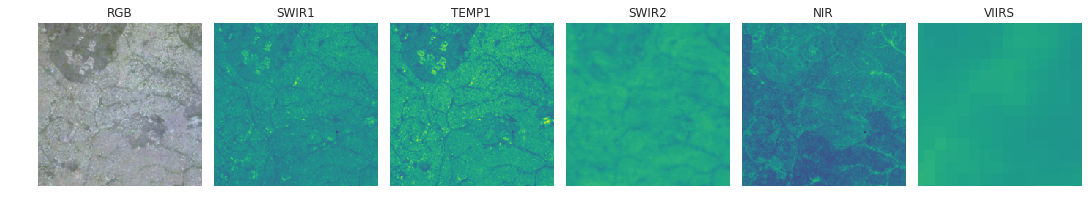

2-th highest wealth: 2.565660, loc = nigeria 2015 (6.470417, 7.487631)


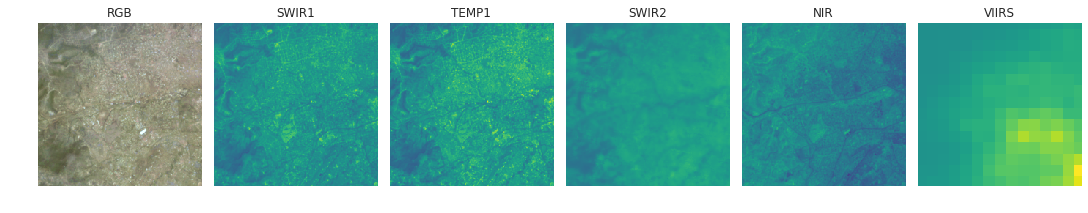

3-th highest wealth: 2.422774, loc = nigeria 2015 (5.535456, 7.531536)


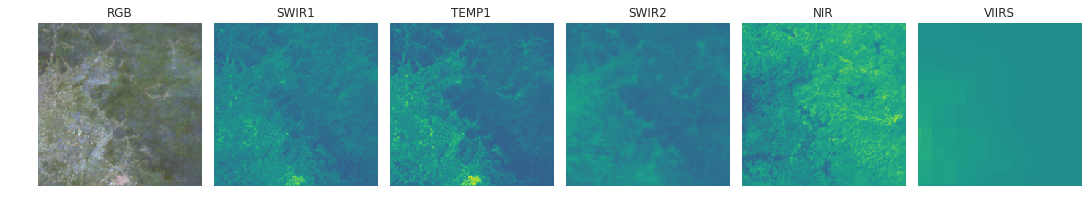

4-th highest wealth: 2.308109, loc = nigeria 2015 (4.860018, 7.058599)


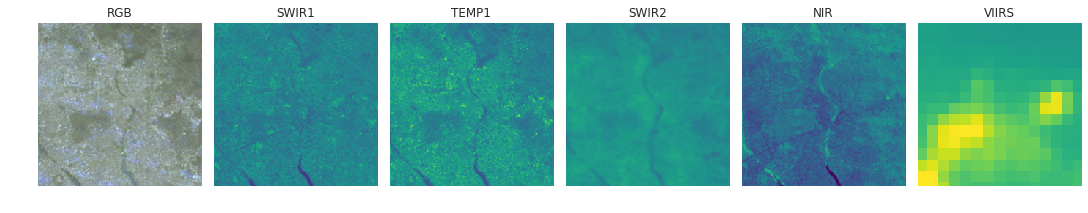

5-th highest wealth: 2.297014, loc = nigeria 2015 (5.011590, 7.949626)


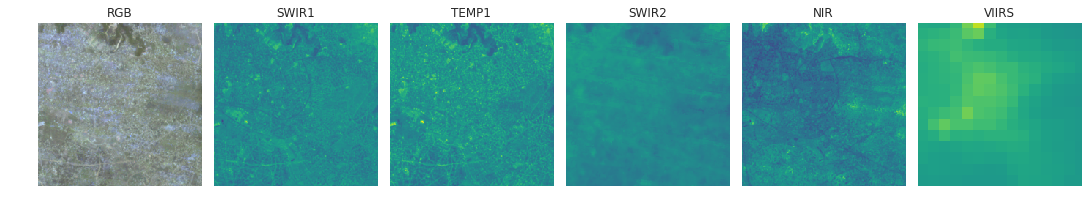

6-th highest wealth: 2.268149, loc = nigeria 2010 (5.535456, 7.531536)


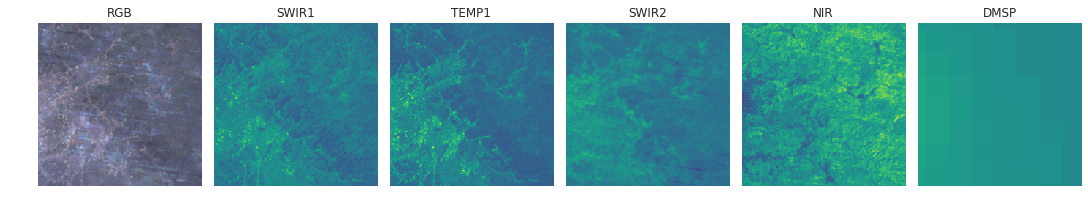

7-th highest wealth: 2.253869, loc = nigeria 2010 (11.987756, 8.529767)


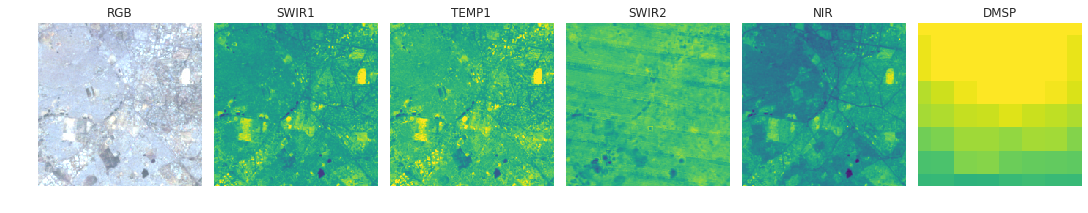

8-th highest wealth: 2.253066, loc = nigeria 2010 (7.431634, 3.951272)


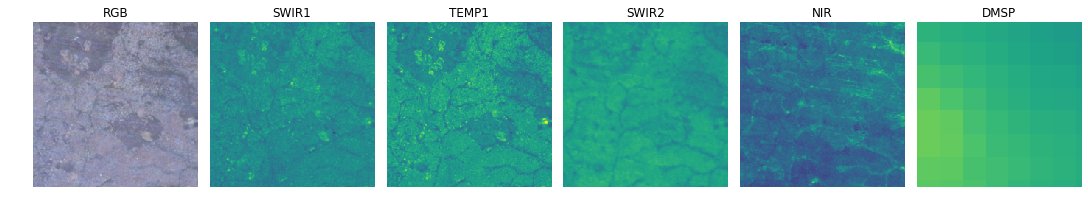

In [41]:
indices = np.argsort(labels)[::-1][:K]  # indices of K wealthiest images
images = get_images(tfrecord_paths[indices])
title_str = '{k}-th highest wealth: {label:.06f}, loc = {country} {year} ({lat:.06f}, {lon:.06f})'
plot_images_by_wealth(indices, images, labels, years, locs,
                      country_labels=country_labels,
                      countries=dataset_constants.LSMS_COUNTRIES,
                      title_str=title_str)

## Lowest wealth

1-th lowest wealth: -1.363729, loc = ethiopia 2015 (3.982931, 38.491367)


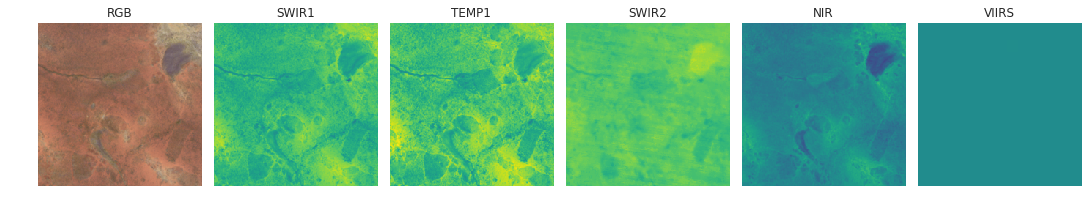

2-th lowest wealth: -1.317778, loc = ethiopia 2015 (8.400071, 33.938507)


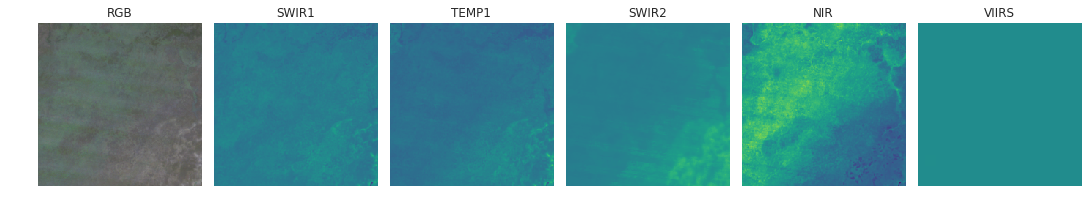

3-th lowest wealth: -1.317778, loc = uganda 2005 (3.086549, 34.137653)


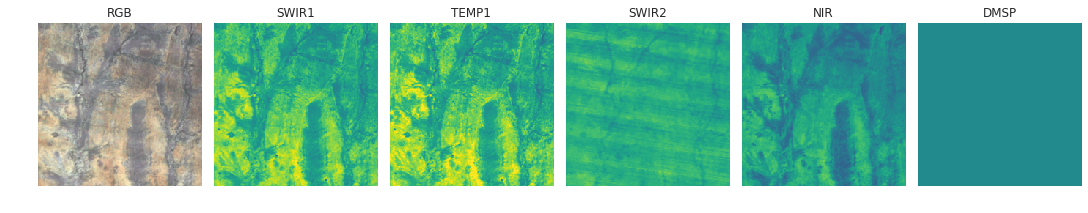

4-th lowest wealth: -1.317778, loc = uganda 2013 (2.581154, 34.575676)


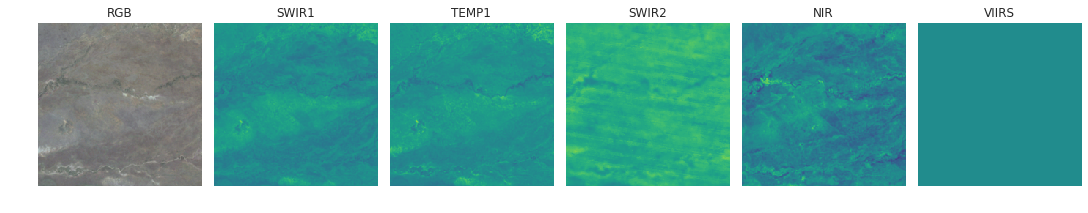

5-th lowest wealth: -1.317778, loc = ethiopia 2011 (12.801716, 36.930313)


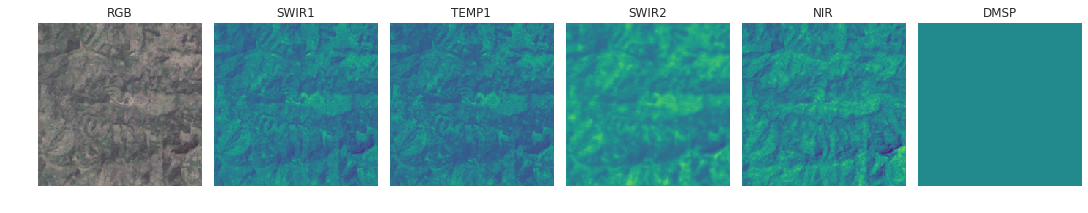

6-th lowest wealth: -1.317778, loc = uganda 2005 (2.581154, 34.575676)


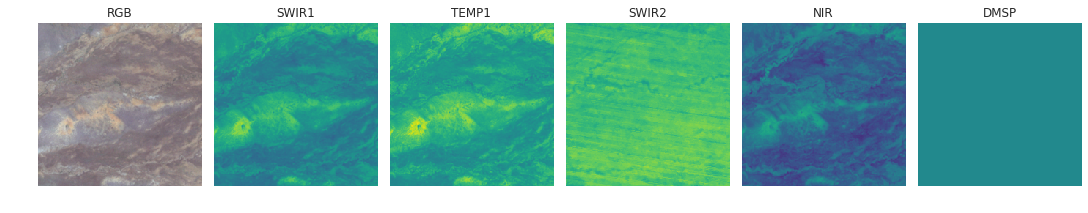

7-th lowest wealth: -1.317778, loc = uganda 2009 (2.581154, 34.575676)


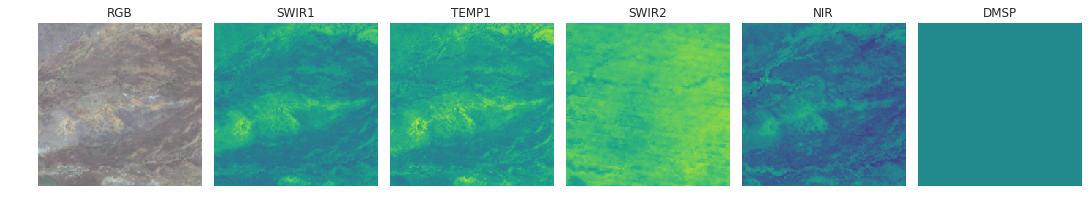

8-th lowest wealth: -1.317778, loc = ethiopia 2015 (12.254391, 38.652576)


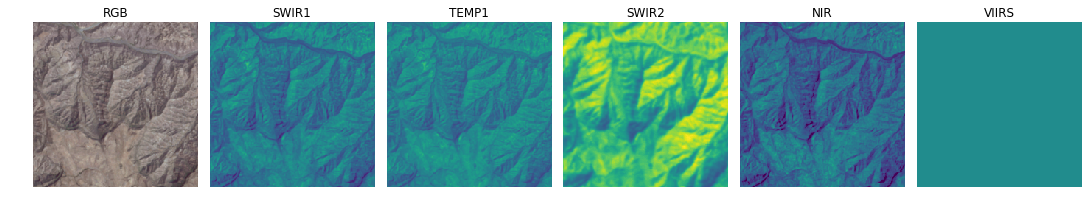

In [42]:
indices = np.argsort(labels)[:K]  # indices of K poorest images
images = get_images(tfrecord_paths[indices])
title_str = '{k}-th lowest wealth: {label:.06f}, loc = {country} {year} ({lat:.06f}, {lon:.06f})'
plot_images_by_wealth(indices, images, labels, years, locs,
                      country_labels=country_labels,
                      countries=dataset_constants.LSMS_COUNTRIES,
                      title_str=title_str)